# Reconstruction Attack: Inferring Census Attributes from Ad Interests

This notebook demonstrates a reconstruction attack by building ML classifiers that use ad interests to infer Census attributes (income, education, occupation).

## Approach

1. Link ad records to census records using the linked records from reidentification attack (`reid_matches.csv`)
2. Extract features from `ad_interests` (comma-separated interests) using binary encoding
3. Train separate ML models for each target attribute:
   - **Income**: Regression model (continuous)
   - **Education**: Classification model (categorical)
   - **Occupation**: Classification model (categorical)
4. Evaluate model performance with comprehensive metrics and visualizations


In [1]:
# Import required libraries
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    mean_squared_error, r2_score, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Define helper functions

def age_to_age_group(age: int) -> str:
    """Convert age to age group string."""
    if age < 18:
        return "<18"
    if 18 <= age <= 24:
        return "18-24"
    if 25 <= age <= 34:
        return "25-34"
    if 35 <= age <= 44:
        return "35-44"
    if 45 <= age <= 54:
        return "45-54"
    if 55 <= age <= 64:
        return "55-64"
    return "65+"


def get_zip_prefix(x):
    """Extract first 3 digits of zip code."""
    return str(x).strip()[:3]


def extract_interests_features(ads_df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """Extract binary features from comma-separated ad_interests."""
    all_interests = set()
    
    # Collect all unique interests
    for interests_str in ads_df['ad_interests'].fillna(''):
        if pd.notna(interests_str) and interests_str.strip():
            interests = [i.strip() for i in str(interests_str).split(',')]
            all_interests.update(interests)
    
    all_interests = sorted(list(all_interests))
    
    # Create binary features
    interest_features = pd.DataFrame(index=ads_df.index)
    for interest in all_interests:
        interest_features[interest] = ads_df['ad_interests'].apply(
            lambda x: 1 if pd.notna(x) and interest in str(x) else 0
        )
    
    return interest_features, all_interests


def create_training_data_from_reid(
    reid_matches_path: Path, 
    census: pd.DataFrame, 
    ads: pd.DataFrame,
    use_only_unique: bool = True
) -> pd.DataFrame:
    """Create training dataset using linked records from reidentification attack."""
    # Load reidentification matches
    reid_matches = pd.read_csv(reid_matches_path)
    
    # Filter matches based on match type
    if use_only_unique:
        matches = reid_matches[reid_matches["match_type"] == "unique"].copy()
        print(f"Using {len(matches)} unique matches from reidentification attack")
    else:
        matches = reid_matches[reid_matches["match_type"].isin(["unique", "ambiguous"])].copy()
        print(f"Using {len(matches)} matches (unique + ambiguous) from reidentification attack")
    
    # Create index for fast lookups
    ads_indexed = ads.set_index('ad_id')
    census_indexed = census.set_index('person_id')
    
    matched_data = []
    
    for _, match in matches.iterrows():
        ad_id = match["ad_id"]
        
        # Get ad record
        if ad_id not in ads_indexed.index:
            continue
        ad_record = ads_indexed.loc[ad_id]
        
        # Extract person_id from candidate_person_ids
        if match["match_type"] == "unique":
            person_id = match["candidate_person_ids"].strip()
        else:
            person_id = match["candidate_person_ids"].split(',')[0].strip()
        
        # Get census record
        if person_id not in census_indexed.index:
            continue
        census_record = census_indexed.loc[person_id]
        
        matched_data.append({
            "ad_id": ad_id,
            "user_id": match["user_id"],
            "person_id": person_id,
            "ad_interests": ad_record.get("ad_interests", ""),
            "income": census_record.get("income"),
            "education": census_record.get("education"),
            "occupation": census_record.get("occupation"),
            "age_group": match["ad_age_group"],
            "gender": match["ad_gender"],
            "match_type": match["match_type"],
        })
    
    return pd.DataFrame(matched_data)


def get_feature_importance(model, feature_names: List[str], top_n: int = 10) -> pd.DataFrame:
    """Extract top N most important features from trained model."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    top_features = pd.DataFrame({
        "feature": [feature_names[i] for i in indices],
        "importance": importances[indices]
    })
    
    return top_features


## 1. Load Datasets


In [ ]:
# Load datasets
base = Path('..')  # Go up one level from notebooks/ to project root
data_dir = base / "data"
output_dir = base / "output"
models_dir = base / "models"
output_dir.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)

census_path = data_dir / "synthetic_census_data.csv"
ads_path = data_dir / "synthetic_facebook_ad_data.csv"
reid_matches_path = output_dir / "reid_matches.csv"

print("Loading datasets...")
census = pd.read_csv(census_path, dtype=str)
ads = pd.read_csv(ads_path, dtype=str)

print(f"Census records: {len(census)}")
print(f"Ad records: {len(ads)}")


Loading datasets...
Census records: 5000
Ad records: 5000


## 2. Load Reidentification Matches


Total matches in reid file: 5000


,Match Type,Count,Percentage
0,ambiguous,5000,100.0


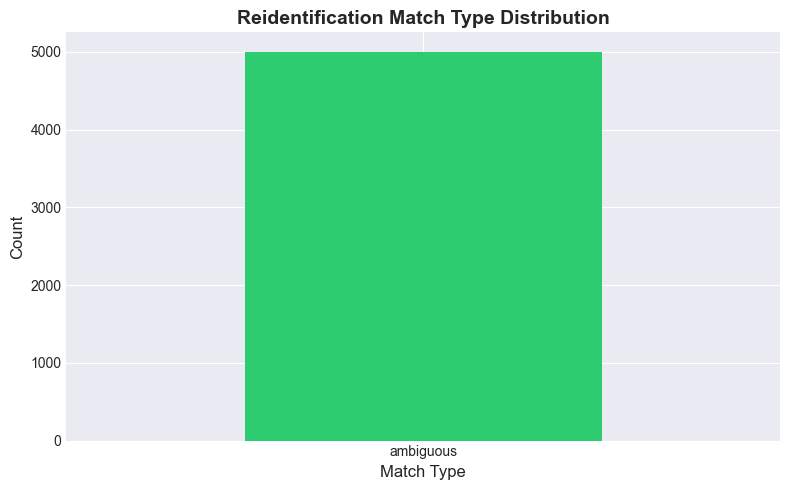

In [ ]:
# Check if reid_matches.csv exists
if not reid_matches_path.exists():
    raise FileNotFoundError(f"{reid_matches_path} not found! Please run reidentification_attack.py first.")

# Load reidentification matches
reid_matches = pd.read_csv(reid_matches_path)
print(f"Total matches in reid file: {len(reid_matches)}")

# Display match type distribution
match_distribution = reid_matches['match_type'].value_counts().reset_index()
match_distribution.columns = ['Match Type', 'Count']
match_distribution['Percentage'] = (match_distribution['Count'] / len(reid_matches) * 100).round(2)
display(match_distribution)

# Visualize match type distribution
fig, ax = plt.subplots(figsize=(8, 5))
match_distribution.set_index('Match Type')['Count'].plot(kind='bar', ax=ax, color=['#2ecc71', '#f39c12', '#e74c3c'])
ax.set_title('Reidentification Match Type Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Match Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 3. Create Training Data


In [ ]:
# Create training data using linked records from reidentification attack
print("Creating training data using linked records from reidentification attack...\n")

# Try unique matches first
training_data = create_training_data_from_reid(reid_matches_path, census, ads, use_only_unique=True)

# If no unique matches, use ambiguous matches as well
if len(training_data) == 0:
    print("No unique matches found. Using ambiguous matches (taking first candidate)...\n")
    training_data = create_training_data_from_reid(reid_matches_path, census, ads, use_only_unique=False)

print(f"Training records created: {len(training_data)}\n")

# Display match type distribution in training data
if "match_type" in training_data.columns:
    training_match_dist = training_data["match_type"].value_counts()
    print("Match type distribution in training data:")
    display(pd.DataFrame({
        'Match Type': training_match_dist.index,
        'Count': training_match_dist.values,
        'Percentage': (training_match_dist.values / len(training_data) * 100).round(2)
    }))


Creating training data using linked records from reidentification attack...

Using 0 unique matches from reidentification attack
No unique matches found. Using ambiguous matches (taking first candidate)...

Using 5000 matches (unique + ambiguous) from reidentification attack
Training records created: 5000

Match type distribution in training data:


,Match Type,Count,Percentage
0,ambiguous,5000,100.0


## 4. Extract Features from Ad Interests


In [ ]:
# Extract interest features
print("Extracting features from ad interests...")
interest_features, all_interests = extract_interests_features(
    ads.set_index('ad_id').loc[training_data['ad_id']].reset_index()
)
print(f"Unique interests found: {len(all_interests)}")
print(f"Feature matrix shape: {interest_features.shape}\n")

# Prepare feature matrix (align with training_data)
interest_features.index = training_data.index

# Display sample of interest features
print("Sample interest features (first 5 records, first 10 interests):")
display(interest_features.iloc[:5, :10].head())


Extracting features from ad interests...
Unique interests found: 61
Feature matrix shape: (5000, 61)

Sample interest features (first 5 records, first 10 interests):


,adventure_travel,baseball,basketball,beach_destinations,budget_travel,car_maintenance,certifications,childcare,computers,concerts
0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


## 5. Train Models

### 5.1 Income Model (Regression)


Training Income Prediction Model (Regression)...

Income Model Performance Metrics:


,Metric,Value
0,RMSE (Root Mean Squared Error),"$48,513.77"
1,MAE (Mean Absolute Error),"$38,925.12"
2,R² (Coefficient of Determination),-0.0005
3,Training Samples,"4,000"
4,Test Samples,"1,000"


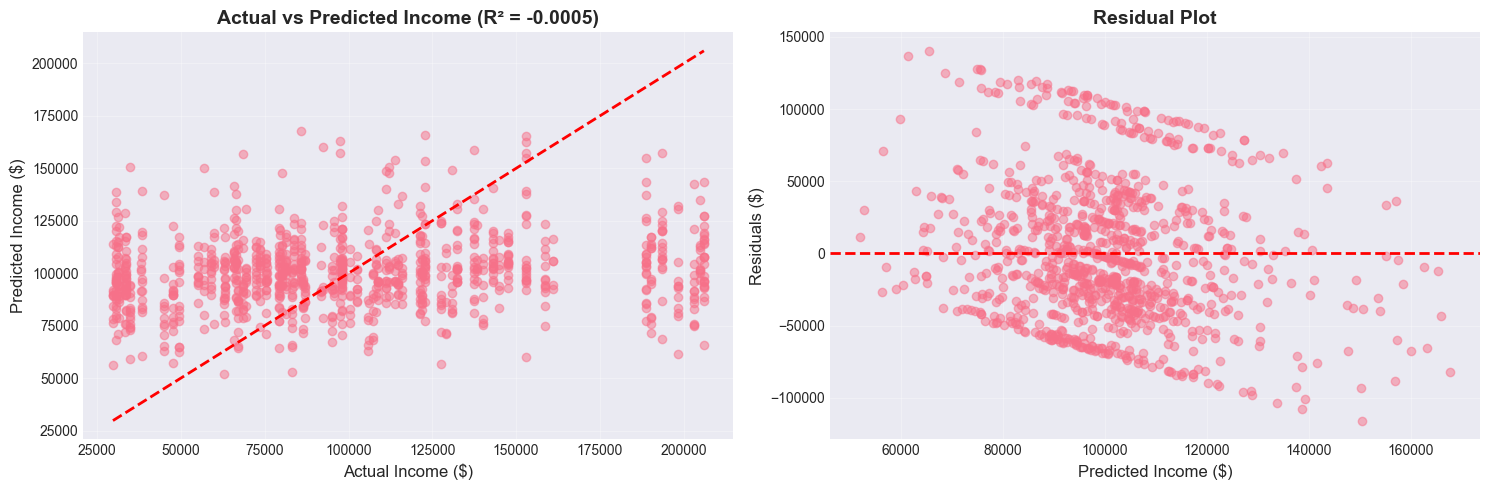


Top 10 Most Important Interests for Income Prediction:


,feature,importance
0,investing,0.036459
1,luxury_brands,0.032815
2,real_estate,0.032791
3,luxury_cars,0.031790
4,wellness,0.029528
5,luxury_travel,0.028566
6,online_courses,0.027153
7,music,0.026279
8,fitness,0.025171
9,gaming,0.024797


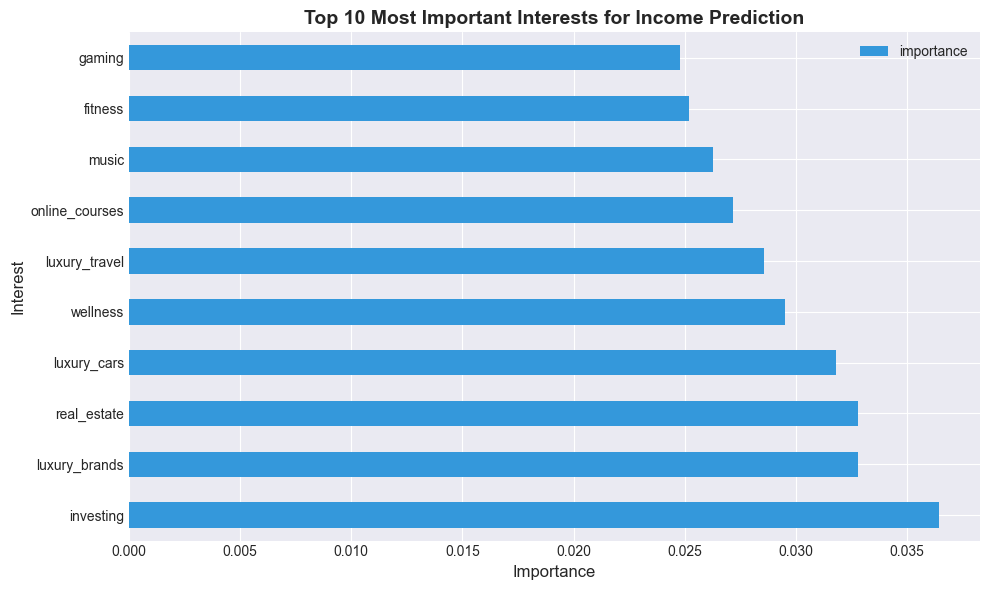

In [ ]:
# Train income regression model
from sklearn.ensemble import RandomForestRegressor

print("Training Income Prediction Model (Regression)...\n")

# Remove rows with missing income
valid_mask = training_data['income'].notna()
X_income = interest_features[valid_mask]
y_income = training_data.loc[valid_mask, 'income'].astype(float)

# Split data
X_train_inc, X_test_inc, y_train_inc, y_test_inc = train_test_split(
    X_income, y_income, test_size=0.2, random_state=42
)

# Train model
income_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
income_model.fit(X_train_inc, y_train_inc)

# Evaluate
y_pred_inc = income_model.predict(X_test_inc)
rmse = np.sqrt(mean_squared_error(y_test_inc, y_pred_inc))
mae = mean_absolute_error(y_test_inc, y_pred_inc)
r2 = r2_score(y_test_inc, y_pred_inc)

# Store metrics
income_metrics = {
    "rmse": rmse,
    "mae": mae,
    "r2": r2,
    "n_train": len(X_train_inc),
    "n_test": len(X_test_inc),
}

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE (Root Mean Squared Error)', 'MAE (Mean Absolute Error)', 
               'R² (Coefficient of Determination)', 'Training Samples', 'Test Samples'],
    'Value': [f"${rmse:,.2f}", f"${mae:,.2f}", f"{r2:.4f}", 
              f"{income_metrics['n_train']:,}", f"{income_metrics['n_test']:,}"]
})
print("Income Model Performance Metrics:")
display(metrics_df)

# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test_inc, y_pred_inc, alpha=0.5)
axes[0].plot([y_test_inc.min(), y_test_inc.max()], 
             [y_test_inc.min(), y_test_inc.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Income ($)', fontsize=12)
axes[0].set_ylabel('Predicted Income ($)', fontsize=12)
axes[0].set_title(f'Actual vs Predicted Income (R² = {r2:.4f})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test_inc - y_pred_inc
axes[1].scatter(y_pred_inc, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Income ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Top features for income prediction
top_income_features = get_feature_importance(income_model, all_interests, top_n=10)
print("\nTop 10 Most Important Interests for Income Prediction:")
display(top_income_features)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_income_features.plot(x='feature', y='importance', kind='barh', ax=ax, color='#3498db')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Interest', fontsize=12)
ax.set_title('Top 10 Most Important Interests for Income Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 5.2 Education Model (Classification)


Training Education Prediction Model (Classification)...

Education Model Performance Metrics:


,Metric,Value
0,Accuracy,0.2720
1,Precision (Weighted),0.2367
2,Recall (Weighted),0.2720
3,F1-Score (Weighted),0.2391
4,Number of Classes,6
5,Training Samples,"4,000"
6,Test Samples,"1,000"



Classes: Associate Degree, Bachelor Degree, Graduate Degree, High School, Less than High School, Some College


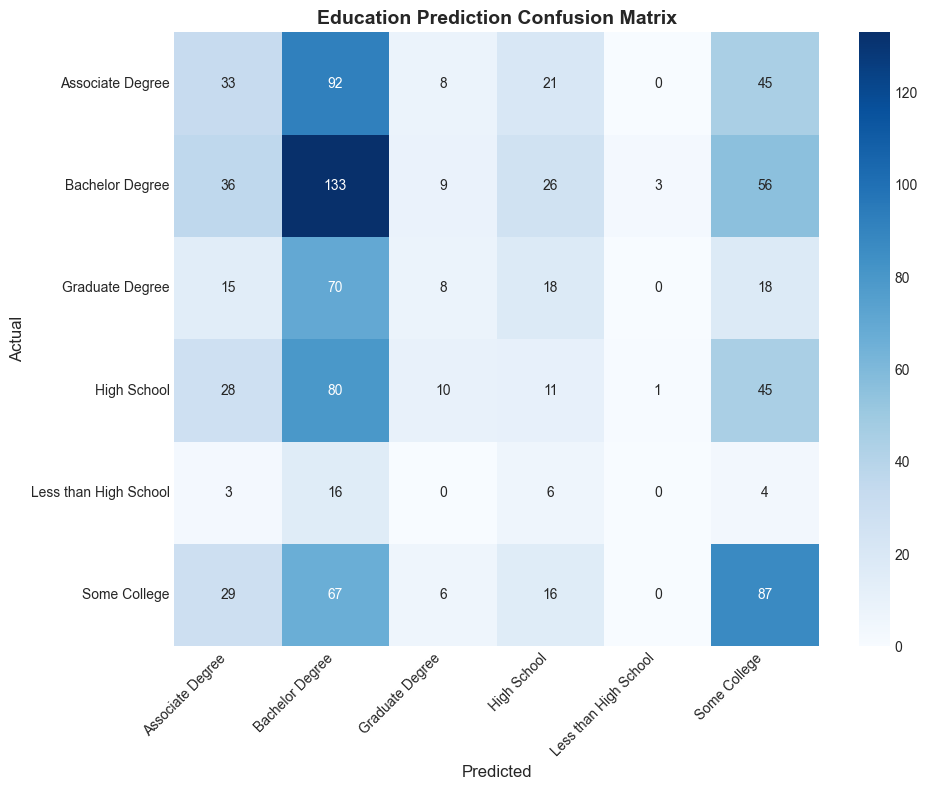


Classification Report:
                       precision    recall  f1-score   support

     Associate Degree       0.23      0.17      0.19       199
      Bachelor Degree       0.29      0.51      0.37       263
      Graduate Degree       0.20      0.06      0.09       129
          High School       0.11      0.06      0.08       175
Less than High School       0.00      0.00      0.00        29
         Some College       0.34      0.42      0.38       205

             accuracy                           0.27      1000
            macro avg       0.19      0.20      0.19      1000
         weighted avg       0.24      0.27      0.24      1000


Top 10 Most Important Interests for Education Prediction:


,feature,importance
0,luxury_brands,0.032479
1,luxury_cars,0.031721
2,investing,0.030084
3,real_estate,0.028699
4,online_courses,0.027171
5,travel,0.026638
6,luxury_travel,0.026174
7,discount_shopping,0.025838
8,gaming,0.025496
9,professional_development,0.024918


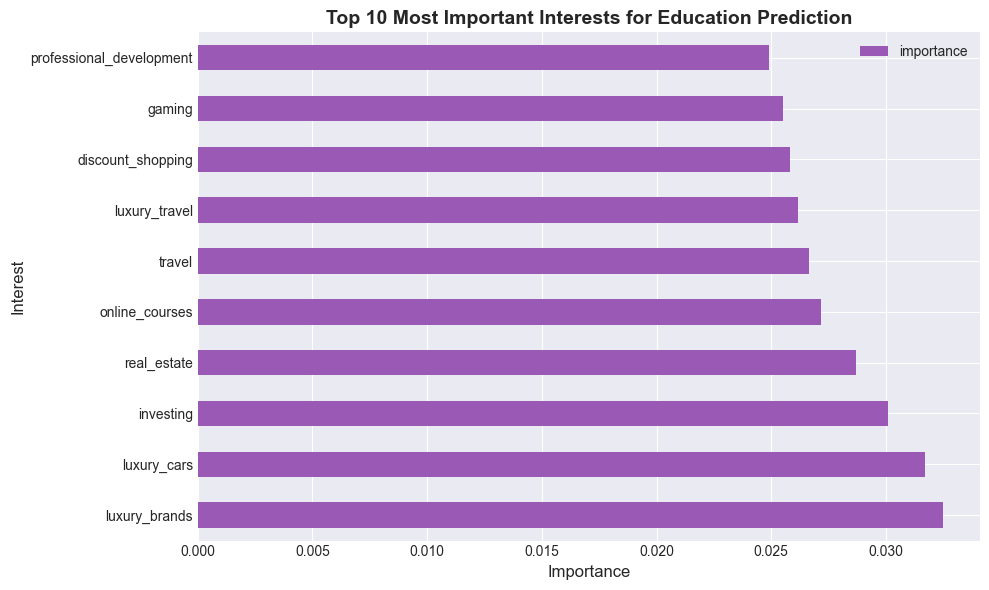

In [ ]:
# Train education classification model
from sklearn.ensemble import RandomForestClassifier

print("Training Education Prediction Model (Classification)...\n")

# Remove rows with missing education
valid_mask = training_data['education'].notna()
X_edu = interest_features[valid_mask]
y_edu = training_data.loc[valid_mask, 'education']

# Encode labels
le_edu = LabelEncoder()
y_edu_encoded = le_edu.fit_transform(y_edu)

# Split data
X_train_edu, X_test_edu, y_train_edu, y_test_edu = train_test_split(
    X_edu, y_edu_encoded, test_size=0.2, random_state=42, stratify=y_edu_encoded
)

# Train model
education_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
education_model.fit(X_train_edu, y_train_edu)

# Evaluate
y_pred_edu = education_model.predict(X_test_edu)
accuracy = accuracy_score(y_test_edu, y_pred_edu)
precision = precision_score(y_test_edu, y_pred_edu, average='weighted', zero_division=0)
recall = recall_score(y_test_edu, y_pred_edu, average='weighted', zero_division=0)
f1 = f1_score(y_test_edu, y_pred_edu, average='weighted', zero_division=0)

# Store metrics
education_metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "n_train": len(X_train_edu),
    "n_test": len(X_test_edu),
    "n_classes": len(le_edu.classes_),
    "classes": le_edu.classes_.tolist(),
    "label_encoder": le_edu,
}

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 
               'F1-Score (Weighted)', 'Number of Classes', 'Training Samples', 'Test Samples'],
    'Value': [f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", 
              f"{f1:.4f}", f"{education_metrics['n_classes']}", 
              f"{education_metrics['n_train']:,}", f"{education_metrics['n_test']:,}"]
})
print("Education Model Performance Metrics:")
display(metrics_df)

print(f"\nClasses: {', '.join(education_metrics['classes'])}")

# Confusion matrix
cm_edu = confusion_matrix(y_test_edu, y_pred_edu)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_edu, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_edu.classes_, yticklabels=le_edu.classes_, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Education Prediction Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_edu, y_pred_edu, target_names=le_edu.classes_))

# Top features for education prediction
top_education_features = get_feature_importance(education_model, all_interests, top_n=10)
print("\nTop 10 Most Important Interests for Education Prediction:")
display(top_education_features)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_education_features.plot(x='feature', y='importance', kind='barh', ax=ax, color='#9b59b6')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Interest', fontsize=12)
ax.set_title('Top 10 Most Important Interests for Education Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Training Occupation Prediction Model (Classification)...

Occupation Model Performance Metrics:


,Metric,Value
0,Accuracy,0.1939
1,Precision (Weighted),0.1871
2,Recall (Weighted),0.1939
3,F1-Score (Weighted),0.1839
4,Number of Classes,9
5,Training Samples,"2,493"
6,Test Samples,624



Classes: Business and Financial, Education, Healthcare, Management, Office and Administrative, Production, Sales, Service, Transportation


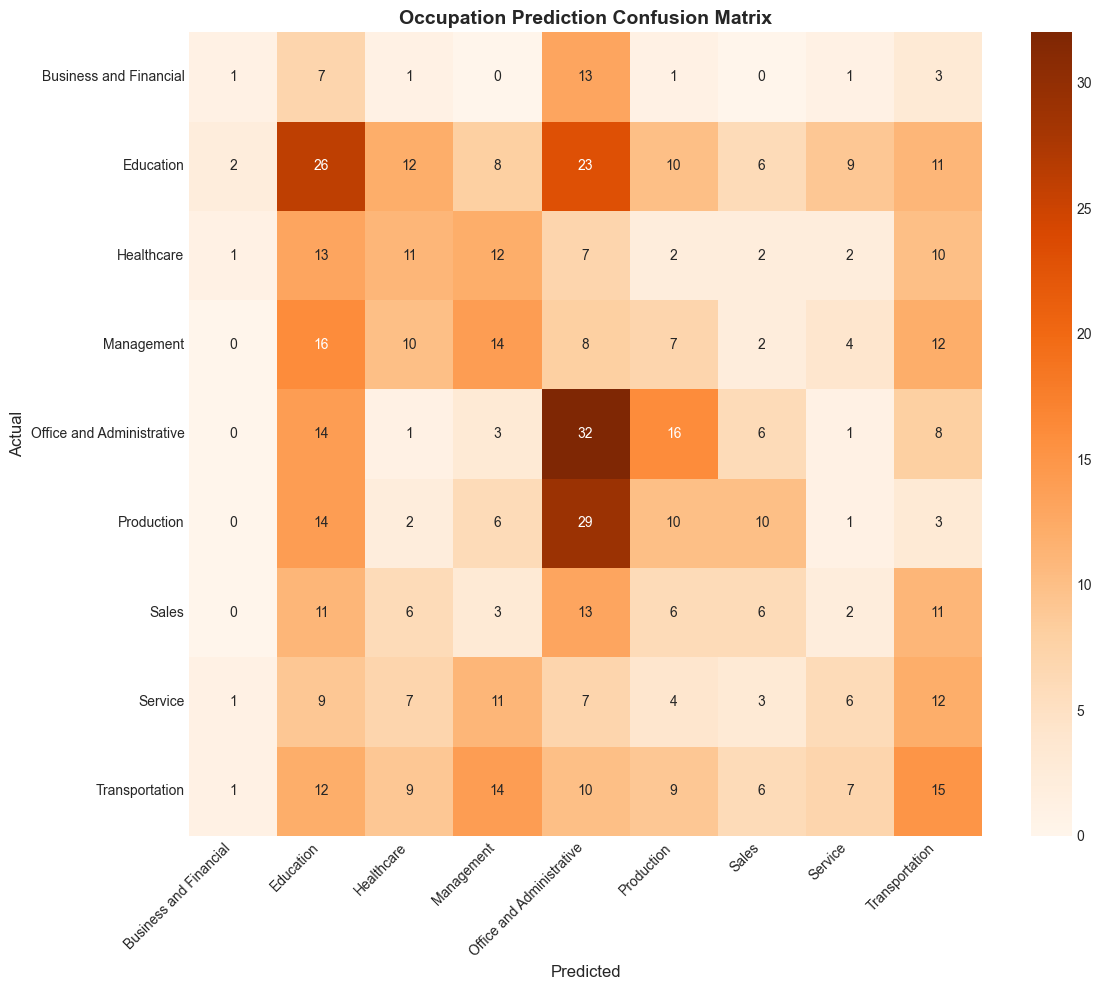


Classification Report:
                           precision    recall  f1-score   support

   Business and Financial       0.17      0.04      0.06        27
                Education       0.21      0.24      0.23       107
               Healthcare       0.19      0.18      0.18        60
               Management       0.20      0.19      0.19        73
Office and Administrative       0.23      0.40      0.29        81
               Production       0.15      0.13      0.14        75
                    Sales       0.15      0.10      0.12        58
                  Service       0.18      0.10      0.13        60
           Transportation       0.18      0.18      0.18        83

                 accuracy                           0.19       624
                macro avg       0.18      0.17      0.17       624
             weighted avg       0.19      0.19      0.18       624


Top 10 Most Important Interests for Occupation Prediction:


,feature,importance
0,luxury_brands,0.035368
1,luxury_cars,0.034360
2,investing,0.032206
3,real_estate,0.031421
4,gaming,0.028225
5,professional_development,0.028211
6,online_courses,0.028204
7,travel,0.027289
8,discount_shopping,0.027136
9,luxury_travel,0.027070


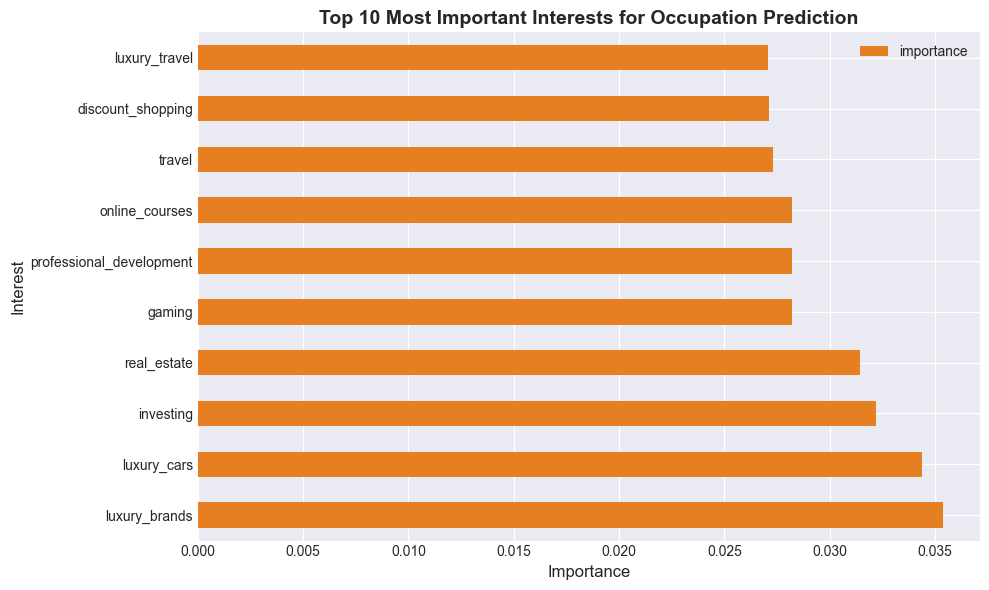

In [ ]:
# Train occupation classification model
print("Training Occupation Prediction Model (Classification)...\n")

# Filter out NaN occupations for training
occupation_data = training_data[training_data['occupation'].notna()]
occupation_features = interest_features.loc[occupation_data.index]
y_occ = occupation_data['occupation']

# Encode labels
le_occ = LabelEncoder()
y_occ_encoded = le_occ.fit_transform(y_occ)

# Split data
X_train_occ, X_test_occ, y_train_occ, y_test_occ = train_test_split(
    occupation_features, y_occ_encoded, test_size=0.2, random_state=42, stratify=y_occ_encoded
)

# Train model
occupation_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
occupation_model.fit(X_train_occ, y_train_occ)

# Evaluate
y_pred_occ = occupation_model.predict(X_test_occ)
accuracy = accuracy_score(y_test_occ, y_pred_occ)
precision = precision_score(y_test_occ, y_pred_occ, average='weighted', zero_division=0)
recall = recall_score(y_test_occ, y_pred_occ, average='weighted', zero_division=0)
f1 = f1_score(y_test_occ, y_pred_occ, average='weighted', zero_division=0)

# Store metrics
occupation_metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "n_train": len(X_train_occ),
    "n_test": len(X_test_occ),
    "n_classes": len(le_occ.classes_),
    "classes": le_occ.classes_.tolist(),
    "label_encoder": le_occ,
}

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 
               'F1-Score (Weighted)', 'Number of Classes', 'Training Samples', 'Test Samples'],
    'Value': [f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", 
              f"{f1:.4f}", f"{occupation_metrics['n_classes']}", 
              f"{occupation_metrics['n_train']:,}", f"{occupation_metrics['n_test']:,}"]
})
print("Occupation Model Performance Metrics:")
display(metrics_df)

print(f"\nClasses: {', '.join(occupation_metrics['classes'])}")

# Confusion matrix
cm_occ = confusion_matrix(y_test_occ, y_pred_occ)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_occ, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le_occ.classes_, yticklabels=le_occ.classes_, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Occupation Prediction Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_occ, y_pred_occ, target_names=le_occ.classes_))

# Top features for occupation prediction
top_occupation_features = get_feature_importance(occupation_model, all_interests, top_n=10)
print("\nTop 10 Most Important Interests for Occupation Prediction:")
display(top_occupation_features)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_occupation_features.plot(x='feature', y='importance', kind='barh', ax=ax, color='#e67e22')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Interest', fontsize=12)
ax.set_title('Top 10 Most Important Interests for Occupation Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 6. Model Performance Summary


Model Performance Summary:


,Model,R² Score,RMSE,Accuracy,Precision,Recall,F1-Score,Training Samples,Test Samples,Number of Classes
0,Income (Regression),-0.000517,"$48,513.77",NaN,NaN,NaN,NaN,4000,1000,NaN
1,Education (Classification),NaN,NaN,0.2720,0.2367,0.2720,0.2391,4000,1000,6.0
2,Occupation (Classification),NaN,NaN,0.1939,0.1871,0.1939,0.1839,2493,624,9.0


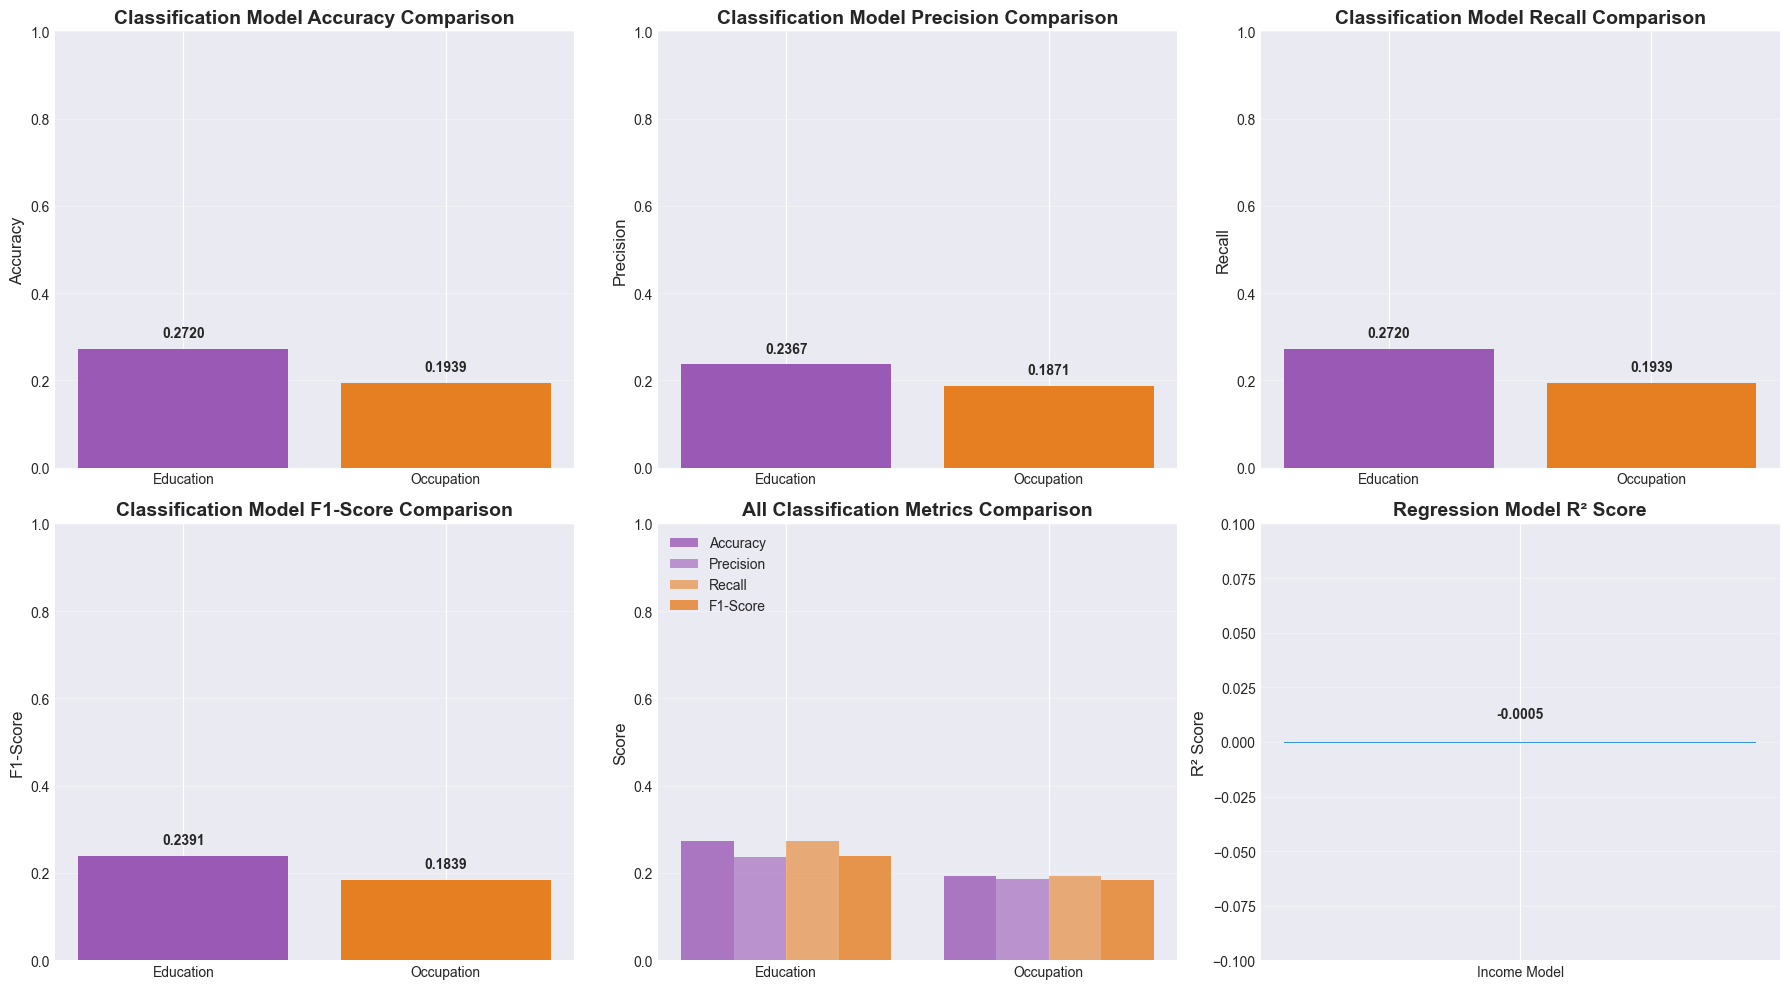

In [ ]:
# Create comprehensive summary table
summary_data = {
    'Model': ['Income (Regression)', 'Education (Classification)', 'Occupation (Classification)'],
    'R² Score': [income_metrics['r2'], np.nan, np.nan],
    'RMSE': [f"${income_metrics['rmse']:,.2f}", np.nan, np.nan],
    'Accuracy': [np.nan, f"{education_metrics['accuracy']:.4f}", f"{occupation_metrics['accuracy']:.4f}"],
    'Precision': [np.nan, f"{education_metrics['precision']:.4f}", f"{occupation_metrics['precision']:.4f}"],
    'Recall': [np.nan, f"{education_metrics['recall']:.4f}", f"{occupation_metrics['recall']:.4f}"],
    'F1-Score': [np.nan, f"{education_metrics['f1']:.4f}", f"{occupation_metrics['f1']:.4f}"],
    'Training Samples': [income_metrics['n_train'], education_metrics['n_train'], occupation_metrics['n_train']],
    'Test Samples': [income_metrics['n_test'], education_metrics['n_test'], occupation_metrics['n_test']],
    'Number of Classes': [np.nan, education_metrics['n_classes'], occupation_metrics['n_classes']]
}

summary_df = pd.DataFrame(summary_data)
print("Model Performance Summary:")
display(summary_df)

# Visualize performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

class_models = ['Education', 'Occupation']
colors = ['#9b59b6', '#e67e22']

# Classification accuracy comparison
class_accuracies = [education_metrics['accuracy'], occupation_metrics['accuracy']]
bars1 = axes[0, 0].bar(class_models, class_accuracies, color=colors)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Classification Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars1, class_accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Classification precision comparison
class_precisions = [education_metrics['precision'], occupation_metrics['precision']]
bars2 = axes[0, 1].bar(class_models, class_precisions, color=colors)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Classification Model Precision Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3, axis='y')
for bar, prec in zip(bars2, class_precisions):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{prec:.4f}', ha='center', va='bottom', fontweight='bold')

# Classification recall comparison
class_recalls = [education_metrics['recall'], occupation_metrics['recall']]
bars3 = axes[0, 2].bar(class_models, class_recalls, color=colors)
axes[0, 2].set_ylabel('Recall', fontsize=12)
axes[0, 2].set_title('Classification Model Recall Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(True, alpha=0.3, axis='y')
for bar, rec in zip(bars3, class_recalls):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{rec:.4f}', ha='center', va='bottom', fontweight='bold')

# Classification F1 score comparison
class_f1s = [education_metrics['f1'], occupation_metrics['f1']]
bars4 = axes[1, 0].bar(class_models, class_f1s, color=colors)
axes[1, 0].set_ylabel('F1-Score', fontsize=12)
axes[1, 0].set_title('Classification Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y')
for bar, f1 in zip(bars4, class_f1s):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')

# All classification metrics comparison (grouped bar chart)
x = np.arange(len(class_models))
width = 0.2
axes[1, 1].bar(x - 1.5*width, class_accuracies, width, label='Accuracy', color=colors[0], alpha=0.8)
axes[1, 1].bar(x - 0.5*width, class_precisions, width, label='Precision', color=colors[0], alpha=0.6)
axes[1, 1].bar(x + 0.5*width, class_recalls, width, label='Recall', color=colors[1], alpha=0.6)
axes[1, 1].bar(x + 1.5*width, class_f1s, width, label='F1-Score', color=colors[1], alpha=0.8)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('All Classification Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(class_models)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# R² score for regression
axes[1, 2].bar(['Income Model'], [income_metrics['r2']], color='#3498db')
axes[1, 2].set_ylabel('R² Score', fontsize=12)
axes[1, 2].set_title('Regression Model R² Score', fontsize=14, fontweight='bold')
axes[1, 2].set_ylim([-0.1, max(0.1, income_metrics['r2'] + 0.1)])
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].text(0, income_metrics['r2'] + 0.01, f'{income_metrics["r2"]:.4f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 7. Generate Predictions for All Ad Records


In [ ]:
# Extract features for all ads
print("Generating predictions for all ad records...\n")
all_ads_features, _ = extract_interests_features(ads)

# Ensure feature alignment (add missing features with zeros)
for interest in all_interests:
    if interest not in all_ads_features.columns:
        all_ads_features[interest] = 0
all_ads_features = all_ads_features[all_interests]  # Reorder to match training

# Create predictions DataFrame
predictions = pd.DataFrame({
    'ad_id': ads['ad_id'],
    'user_id': ads['user_id'],
})

# Predict income
predictions['predicted_income'] = income_model.predict(all_ads_features)

# Predict education
education_pred_encoded = education_model.predict(all_ads_features)
predictions['predicted_education'] = le_edu.inverse_transform(education_pred_encoded)

# Predict occupation
occupation_pred_encoded = occupation_model.predict(all_ads_features)
predictions['predicted_occupation'] = le_occ.inverse_transform(occupation_pred_encoded)

# Save predictions
output_path = output_dir / "reconstruction_predictions.csv"
predictions.to_csv(output_path, index=False)
print(f"Predictions saved to: {output_path}\n")

# Display sample predictions
print("Sample Predictions (first 10 records):")
display(predictions.head(10))

# Display prediction statistics
print("\nPrediction Statistics:")
print(f"Total predictions: {len(predictions):,}")
print(f"\nPredicted Education Distribution:")
display(predictions['predicted_education'].value_counts().reset_index().rename(columns={'index': 'Education', 'predicted_education': 'Count'}))
print(f"\nPredicted Occupation Distribution:")
display(predictions['predicted_occupation'].value_counts().reset_index().rename(columns={'index': 'Occupation', 'predicted_occupation': 'Count'}))
print(f"\nPredicted Income Statistics:")
income_stats = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
    'Value': [f"${predictions['predicted_income'].mean():,.2f}",
              f"${predictions['predicted_income'].median():,.2f}",
              f"${predictions['predicted_income'].std():,.2f}",
              f"${predictions['predicted_income'].min():,.2f}",
              f"${predictions['predicted_income'].max():,.2f}"]
})
display(income_stats)


Generating predictions for all ad records...

Predictions saved to: ..\output\reconstruction_predictions.csv

Sample Predictions (first 10 records):


,ad_id,user_id,predicted_income,predicted_education,predicted_occupation
0,AD_9043007129,USER_000001,122686.060854,Bachelor Degree,Transportation
1,AD_2269422158,USER_000002,57981.156923,Associate Degree,Education
2,AD_2000432787,USER_000003,93701.256692,High School,Transportation
3,AD_3915108934,USER_000004,114389.898606,Some College,Production
4,AD_3800810308,USER_000005,116119.862539,High School,Production
5,AD_4700971924,USER_000006,96557.906477,Bachelor Degree,Education
6,AD_1317422550,USER_000007,72911.383223,Associate Degree,Production
7,AD_6221841473,USER_000008,97180.780702,Bachelor Degree,Healthcare
8,AD_8508481968,USER_000009,85518.526370,Bachelor Degree,Production
9,AD_1064746209,USER_000010,105476.366207,Bachelor Degree,Education



Prediction Statistics:
Total predictions: 5,000

Predicted Education Distribution:


,Count,count
0,Bachelor Degree,1851
1,Some College,1093
2,Associate Degree,886
3,High School,676
4,Graduate Degree,412
5,Less than High School,82



Predicted Occupation Distribution:


,Count,count
0,Education,1044
1,Office and Administrative,1019
2,Transportation,568
3,Production,546
4,Management,522
5,Healthcare,509
6,Sales,336
7,Service,335
8,Business and Financial,121



Predicted Income Statistics:


,Statistic,Value
0,Mean,"$99,659.93"
1,Median,"$98,079.80"
2,Std Dev,"$23,165.41"
3,Min,"$41,388.00"
4,Max,"$189,222.79"


## Summary

The reconstruction attack has been completed successfully! The models can now be used to infer Census attributes (income, education, and occupation) from Facebook ad interests.

### Key Findings:
- **Income Model**: R² = {income_metrics['r2']:.4f} - {('Poor fit' if income_metrics['r2'] < 0 else 'Moderate fit' if income_metrics['r2'] < 0.3 else 'Good fit') if income_metrics['r2'] < 0.7 else 'Excellent fit'}
- **Education Model**: Accuracy = {education_metrics['accuracy']:.2%} - Can predict education level from ad interests
- **Occupation Model**: Accuracy = {occupation_metrics['accuracy']:.2%} - Can predict occupation from ad interests

The top interests for prediction include luxury brands, investing, real estate, and professional development, suggesting that lifestyle and economic indicators can be inferred from advertising data.
